In [ ]:
###########################################################
# Purpose: Create a set of random forest models Using     #
# molecular fingerprints to classify chemicals as skin    #
# sensitizers or not                                      #
###########################################################
 

# General data processing libraries
import os
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#chemistry libraries
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, DataStructs

# libraries for graph nn with PyTorch and Pytorch Geometric
import torch
from torch.nn import Linear
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.utils import from_smiles, to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader


In [2]:
fpath = 'C:/Users/kdjanse/OneDrive - Rockline Industries/Desktop/DataSci_Programs/DS Capstone/DataSets/df_skinsens.csv'
skinsens_in = pd.read_csv(fpath)
sens_gcn_data = skinsens_in[['canonicalsmiles', 'sensitizer']]
sens_gcn_data

,canonicalsmiles,sensitizer
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,1
1,CC=O,1
2,C1=CC=C(C=C1)C=O,1
3,C1=CC=C(C=C1)CO,1
4,C1=CC=C(C(=C1)O)O,1
...,...,...
24105,CC1(CN(CCN1)C)C,0
24106,C1=CC(=CC=C1CSC2=NN=C(N2C3=CC=C(C=C3)Br)C4=CC=...,0
24107,C1=CC(=CC=C1C2=CC=NN2)Br,0
24108,C1=COC(=C1)C2=NN=C(S2)N,0


In [3]:
for i, smile in enumerate(sens_gcn_data['canonicalsmiles']):
     try:
          g = from_smiles(smile)
          print(g)
          g.x = g.x.float()
          print(len(g.x))
          y = torch.tensor(sens_gcn_data['sensitizer'][i], dtype=torch.int64)
          g.y = y
          
     except ValueError:
     # Skip any invalid SMILES
          print(f"Invalid SMILES at index {i}: {smile}")
          pass

Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl')
13
Data(x=[3, 9], edge_index=[2, 4], edge_attr=[4, 3], smiles='CC=O')
3
Data(x=[8, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles='C1=CC=C(C=C1)C=O')
8
Data(x=[8, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles='C1=CC=C(C=C1)CO')
8
Data(x=[8, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles='C1=CC=C(C(=C1)O)O')
8
Data(x=[21, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles='C1(=O)C2(C3(C4(C1(C5(C2(C3(C(C45Cl)(Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl')
21
Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 3], smiles='C1=CC(=C(C=C1O)Cl)O')
9
Data(x=[29, 9], edge_index=[2, 64], edge_attr=[64, 3], smiles='CC(CCC(=O)O)C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)O)C)O)O)C')
29
Data(x=[1, 9], edge_index=[2, 0], edge_attr=[0, 3], smiles='[Cl-]')
1
Data(x=[11, 9], edge_index=[2, 24], edge_attr=[24, 3], smiles='C1=CC=C2C(=C1)C=CC(=O)O2')
11
Data(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], smiles='CC(C)C1=

In [4]:
'''
new class to create a torch_geometric.data.Dataset object
to process the data for a GNN.
https://github.com/codetodiscovery/Lipophilicity-GNN/blob/main/pytorchg_lipo.ipynb

'''

class GCNDataset(InMemoryDataset):
    def __init__(self,root, transform=None, pretransform=None, pre_filter=None):
        super().__init__(root, transform, pretransform, pre_filter)
        # this is from version 2.4 of torch_geometric
        # the current tutorial is different
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only = False)  
    @property
    def raw_file_names(self):
        return 'sens_gcn_data.csv'
    @property
    def processed_file_names(self):
        return 'data.dt'
   
    
    def download(self):
        pass

    def process(self):
        data_list = []
        for i, smile in enumerate(sens_gcn_data['canonicalsmiles']):
            try:
                 g = from_smiles(smile)
                 g.x = g.x.float()
                 y = torch.tensor(sens_gcn_data['sensitizer'][i], dtype=torch.int64)
                 g.y = y
                 data_list.append(g)
            
            except ValueError:
            # Skip any invalid SMILES
                print(f"Invalid SMILES at index {i}: {smile}")
                pass
            
        # this is from version 2.4 of torch_geometric
        # the current tutorial is different
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [5]:
dataset = GCNDataset(root = 'C:/Users/kdjanse/KJ_code/data')


In [6]:

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: GCNDataset(24109):
Number of graphs: 24109
Number of features: 9
Number of classes: 2

Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl', y=[1])
Number of nodes: 13
Number of edges: 26
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [7]:
# split the data into train and test

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:19287]  #about 80% of 24109
test_dataset = dataset[19287:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_dataset.y.shape

Number of training graphs: 19287
Number of test graphs: 4822


torch.Size([19287])

In [16]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last = True)

#DataBatch(x=[9, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles=[1], y=[1], batch=[9], ptr=[2])
for step, data in enumerate(train_loader):
    #if len(data.batch)==0:
    print(data)
    print(len(data.batch))
    #print()
    #print('=======')
    #print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(len(data.y))
    #print()

DataBatch(x=[690, 9], edge_index=[2, 1426], edge_attr=[1426, 3], smiles=[32], y=[32], batch=[690], ptr=[33])
690
32
DataBatch(x=[798, 9], edge_index=[2, 1606], edge_attr=[1606, 3], smiles=[32], y=[32], batch=[798], ptr=[33])
798
32
DataBatch(x=[927, 9], edge_index=[2, 1930], edge_attr=[1930, 3], smiles=[32], y=[32], batch=[927], ptr=[33])
927
32
DataBatch(x=[408, 9], edge_index=[2, 824], edge_attr=[824, 3], smiles=[32], y=[32], batch=[408], ptr=[33])
408
32
DataBatch(x=[603, 9], edge_index=[2, 1232], edge_attr=[1232, 3], smiles=[32], y=[32], batch=[603], ptr=[33])
603
32
DataBatch(x=[590, 9], edge_index=[2, 1216], edge_attr=[1216, 3], smiles=[32], y=[32], batch=[590], ptr=[33])
590
32
DataBatch(x=[562, 9], edge_index=[2, 1126], edge_attr=[1126, 3], smiles=[32], y=[32], batch=[562], ptr=[33])
562
32
DataBatch(x=[537, 9], edge_index=[2, 1090], edge_attr=[1090, 3], smiles=[32], y=[32], batch=[537], ptr=[33])
537
32
DataBatch(x=[489, 9], edge_index=[2, 964], edge_attr=[964, 3], smiles=[32]

In [44]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(9, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)


Epoch: 010, train Acc: 0.6276, Train Recall: 0.8218, test Acc: 0.6333, test Prec: 0.5943, test Recall: 0.8231
mismatch
Epoch: 020, train Acc: 0.6323, Train Recall: 0.8462, test Acc: 0.6342, test Prec: 0.5921, test Recall: 0.8447
mismatch
train mismatch
Epoch: 030, train Acc: 0.6826, Train Recall: 0.6390, test Acc: 0.6775, test Prec: 0.6911, test Recall: 0.6352
mismatch
mismatch
mismatch
mismatch
Epoch: 040, train Acc: 0.6907, Train Recall: 0.6324, test Acc: 0.6910, test Prec: 0.7138, test Recall: 0.6322
train mismatch
mismatch
Epoch: 050, train Acc: 0.6938, Train Recall: 0.7064, test Acc: 0.6854, test Prec: 0.6786, test Recall: 0.6978
mismatch
train mismatch
train mismatch
Epoch: 060, train Acc: 0.6807, Train Recall: 0.8180, test Acc: 0.6794, test Prec: 0.6383, test Recall: 0.8193
train mismatch
train mismatch
Epoch: 070, train Acc: 0.7056, Train Recall: 0.6590, test Acc: 0.6966, test Prec: 0.7117, test Recall: 0.6559
mismatch
Epoch: 080, train Acc: 0.6915, Train Recall: 0.8107, test A

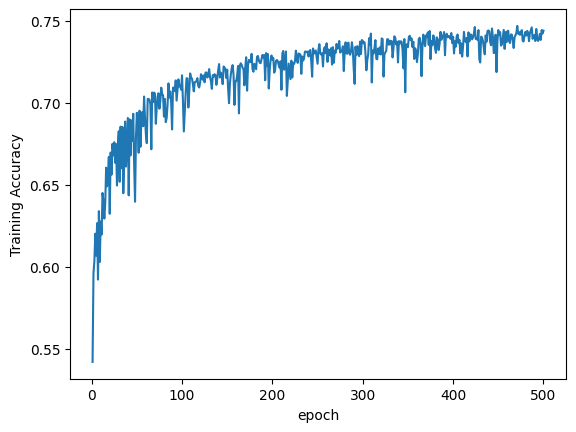

In [ ]:
##########################################
# RUNNING THIS CELL MAY TAKE A LONG TIME #
#   IT TOOK ABOUT 90 MIN ON MY LAPTOP    #
##########################################


model = GCN(hidden_channels=32)
class_wt = torch.tensor([1.1])

optimizer = torch.optim.Adam(model.parameters(), lr=0.00075)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_wt)

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         data.y = data.y.unsqueeze(1).float()
         if len(out) != len(data.y):
            print("train mismatch")
            continue
         else: loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
     

def test(loader):
     model.eval()

     correct=0
     TP = 0
     FP = 0
     TN = 0
     FN = 0
     
     for data in loader:  # Iterate in batches over the training/test dataset.
        
         out = model(data.x, data.edge_index, data.batch)
         data.y = data.y.unsqueeze(1).float()

         pred = (out > 0).float()
         if len(pred) != len(data.y):
            print("mismatch")
            continue
         else: 
            correct += int((pred == data.y).sum())  # total correct predictions for the batch
            #TP = pred == 1 and data.y == 1
            TP += int(((pred == 1) & (data.y == 1)).sum())
            #FP = pred == 1 and data.y == 0
            FP += int(((pred == 1) & (data.y == 0)).sum())
            #TN = pred == 0 and data.y == 0
            TN += int(((pred == 0) & (data.y == 0)).sum())
            #FN = pred == 0 and data.y == 1
            FN += int(((pred == 0) & (data.y == 1)).sum())
            
         acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
         prec = TP / (TP + FP) if (TP + FP) > 0 else 0 
         recall = TP / (FN + TP) if (FN + TP) > 0 else 0
         test_dict = {'acc':acc, 'prec': prec, 'recall':recall}
     return test_dict

metrics_lst = []
for epoch in range(1, 501):
    train()
    train_metrics = test(train_loader)
    test_metrics = test(test_loader)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch:03d}, train Acc: {train_metrics['acc']:.4f}, Train Recall: {train_metrics['recall']:.4f}, test Acc: {test_metrics['acc']:.4f}, test Prec: {test_metrics['prec']:.4f}, test Recall: {test_metrics['recall']:.4f}")
    mets = [epoch, train_metrics['acc'], train_metrics['recall'], test_metrics['acc'], test_metrics['prec'], test_metrics['recall']]
    metrics_lst.append(mets)

GCNmetrics_df = pd.DataFrame(metrics_lst, columns=['epoch', 'Training Accuracy', 'Training Recall', 'Test Set Accuracy', 'Test Set Precision', 'Test Set Recall'])

#plotting the learning curve
sns.lineplot(data= GCNmetrics_df, x='epoch', y='Training Accuracy')

plt.show()


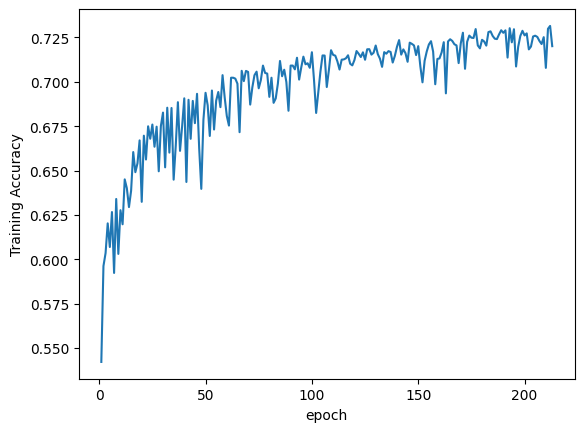

In [51]:
GCNmetrics_df = pd.DataFrame(metrics_lst, columns=['epoch', 'Training Accuracy', 'Training Recall', 'Test Set Accuracy', 'Test Set Precision', 'Test Set Recall'])

#plotting the learning curve
sns.lineplot(data= GCNmetrics_df, x='epoch', y='Training Accuracy')

plt.show()

